In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os

plt.style.use('bmh')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pwd
%load_ext altair

In [2]:
import sys
sys.path.append('../src/')

In [3]:
!ls ../datasets/predicting_house_prices/

data_description.txt  sample_submission.csv train.csv
my_submission.csv     test.csv


# 1) Get Data

## a) Load Data

In [4]:
train_df = pd.read_csv('../datasets/predicting_house_prices/train.csv', sep=',')
print(train_df.shape)
train_df.head(2)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
test_df = pd.read_csv('../datasets/predicting_house_prices/test.csv', sep=',')
sample_submission = pd.read_csv('../datasets/predicting_house_prices/sample_submission.csv', sep=',')
test_df['SalePrice'] = sample_submission['SalePrice']
test_df['log_sale_price'] = np.log(test_df.SalePrice)
print(test_df.shape)
test_df.head(2)

(1459, 82)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_sale_price
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,169277.052498,12.039292
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,187758.393989,12.142911


## b) Break them into numerical and categorical columns

In [41]:
id_cols = ['Id', 'SalePrice']
target_cols = ['log_sale_price']
numeric_cols = [col for col in train_df._get_numeric_data().columns if (col not in target_cols) and (col not in id_cols) and (col not in ['OverallQual'])]
cat_cols = [col for col in train_df.columns if (col not in numeric_cols) and (col not in target_cols) and (col not in id_cols)]
len(numeric_cols), len(target_cols), len(cat_cols), len(numeric_cols) + len(target_cols) + len(cat_cols)

(35, 1, 44, 80)

# 2) Target EDA

<Axes: xlabel='SalePrice', ylabel='Count'>

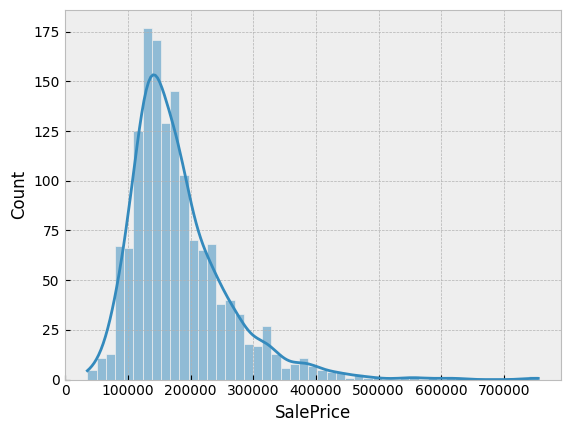

In [42]:
sns.histplot(train_df.SalePrice, kde=True)

In [8]:
# distribution is skewing towards right with a slightly fat tail. lets calculate skewness and kurtosis
# also, target scale is too high. it would be better to convert it to log scale for easy training and handling.

In [43]:
# these numbers are high. we have quite a few prices on the higher end.
train_df.SalePrice.skew(), train_df.SalePrice.kurtosis()

(1.8828757597682129, 6.536281860064529)

In [46]:
# taking log of the target
train_df['log_sale_price'] = np.log(train_df.SalePrice)

In [47]:
id_cols = ['Id', 'SalePrice']
target_cols = ['log_sale_price']
numeric_cols = [col for col in train_df._get_numeric_data().columns if (col not in target_cols) and (col not in id_cols) and (col not in ['OverallQual'])]
cat_cols = [col for col in train_df.columns if (col not in numeric_cols) and (col not in target_cols) and (col not in id_cols)]
len(numeric_cols), len(target_cols), len(cat_cols)

(35, 1, 44)

# 3) Numerical Columns EDA

## a) Descriptive 

In [48]:
train_df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


## b) Coverage

In [49]:
for col in numeric_cols:
    coverage = np.round(train_df[col].notnull().sum()*100 / train_df[col].shape[0], 3)
    if coverage < 100:
        print(col, coverage)

LotFrontage 82.26
MasVnrArea 99.452
GarageYrBlt 94.452


In [50]:
# coverage is almost full for most. we can impute the remaining null values

## c) More Descriptive stats

In [51]:
min_col_list = []
median_col_list = []
max_col_list = []
std_col_list = []
coverage_list = []
for col in numeric_cols:
    coverage = np.round(train_df[col].notnull().sum()*100 / train_df[col].shape[0], 3)
    min_col = train_df[col].min()
    median_col = train_df[col].median()
    max_col = train_df[col].max()
    std_col = train_df[col].std()
    
    coverage_list.append(coverage)
    min_col_list.append(min_col)
    median_col_list.append(median_col)
    max_col_list.append(max_col)
    std_col_list.append(std_col)
describe_df = pd.DataFrame({'col': numeric_cols, 
                            'coverage': coverage_list,
                            'min': min_col_list, 
                            'median': median_col_list, 
                            'max': max_col_list,
                            'std': std_col_list})
print(describe_df.shape)
describe_df['skew_value'] = train_df[numeric_cols].skew().values
describe_df['kurtosis_value'] = train_df[numeric_cols].kurtosis().values
describe_df

(35, 6)


,col,coverage,min,median,max,std,skew_value,kurtosis_value
0,MSSubClass,100.000,20.0,50.0,190.0,42.300571,1.407657,1.580188
1,LotFrontage,82.260,21.0,69.0,313.0,24.284752,2.163569,17.452867
2,LotArea,100.000,1300.0,9478.5,215245.0,9981.264932,12.207688,203.243271
3,OverallCond,100.000,1.0,5.0,9.0,1.112799,0.693067,1.106413
4,YearBuilt,100.000,1872.0,1973.0,2010.0,30.202904,-0.613461,-0.439552
5,YearRemodAdd,100.000,1950.0,1994.0,2010.0,20.645407,-0.503562,-1.272245
6,MasVnrArea,99.452,0.0,0.0,1600.0,181.066207,2.669084,10.082417
7,BsmtFinSF1,100.000,0.0,383.5,5644.0,456.098091,1.685503,11.118236
8,BsmtFinSF2,100.000,0.0,0.0,1474.0,161.319273,4.255261,20.113338
9,BsmtUnfSF,100.000,0.0,477.5,2336.0,441.866955,0.920268,0.474994


### i) Skew

In [52]:
describe_df[describe_df.skew_value>1].sort_values(by='skew_value', ascending=False)

,col,coverage,min,median,max,std,skew_value,kurtosis_value
32,MiscVal,100.000,0.0,0.0,15500.0,496.123024,24.476794,701.003342
31,PoolArea,100.000,0.0,0.0,738.0,40.177307,14.828374,223.268499
2,LotArea,100.000,1300.0,9478.5,215245.0,9981.264932,12.207688,203.243271
29,3SsnPorch,100.000,0.0,0.0,508.0,29.317331,10.304342,123.662379
13,LowQualFinSF,100.000,0.0,0.0,572.0,48.623081,9.011341,83.234817
20,KitchenAbvGr,100.000,0.0,1.0,3.0,0.220338,4.488397,21.532404
8,BsmtFinSF2,100.000,0.0,0.0,1474.0,161.319273,4.255261,20.113338
30,ScreenPorch,100.000,0.0,0.0,480.0,55.757415,4.122214,18.439068
16,BsmtHalfBath,100.000,0.0,0.0,2.0,0.238753,4.103403,16.396642
28,EnclosedPorch,100.000,0.0,0.0,552.0,61.119149,3.089872,10.430766


### ii) Kurtosis

In [53]:
describe_df[describe_df.kurtosis_value>3].sort_values(by='kurtosis_value', ascending=False)

,col,coverage,min,median,max,std,skew_value,kurtosis_value
32,MiscVal,100.000,0.0,0.0,15500.0,496.123024,24.476794,701.003342
31,PoolArea,100.000,0.0,0.0,738.0,40.177307,14.828374,223.268499
2,LotArea,100.000,1300.0,9478.5,215245.0,9981.264932,12.207688,203.243271
29,3SsnPorch,100.000,0.0,0.0,508.0,29.317331,10.304342,123.662379
13,LowQualFinSF,100.000,0.0,0.0,572.0,48.623081,9.011341,83.234817
20,KitchenAbvGr,100.000,0.0,1.0,3.0,0.220338,4.488397,21.532404
8,BsmtFinSF2,100.000,0.0,0.0,1474.0,161.319273,4.255261,20.113338
30,ScreenPorch,100.000,0.0,0.0,480.0,55.757415,4.122214,18.439068
1,LotFrontage,82.260,21.0,69.0,313.0,24.284752,2.163569,17.452867
16,BsmtHalfBath,100.000,0.0,0.0,2.0,0.238753,4.103403,16.396642


In [54]:
# skew and kurtosis value for a few columns look high. so, it's better to use robustscaler while scaling.

# 3) Numeric cols vs Target

In [55]:
corr_df = train_df[numeric_cols].corrwith(train_df['log_sale_price']).reset_index()
corr_df.columns = ['numerical_col', 'correlation_coefficient']
print(corr_df.shape)
corr_df.sample(7)

(35, 2)


,numerical_col,correlation_coefficient
21,TotRmsAbvGrd,0.534422
33,MoSold,0.057329
14,GrLivArea,0.700927
12,2ndFlrSF,0.319300
13,LowQualFinSF,-0.037963
0,MSSubClass,-0.073959
18,HalfBath,0.313982


In [56]:
high_correlated_fields = corr_df[corr_df.correlation_coefficient>0.5].numerical_col.tolist()
len(high_correlated_fields)

10

In [57]:
# these are highly correlated fields with target. we should use them in modeling
corr_df[corr_df.correlation_coefficient>0.5].sort_values(by='correlation_coefficient', ascending=False)

,numerical_col,correlation_coefficient
14,GrLivArea,0.700927
24,GarageCars,0.680625
25,GarageArea,0.650888
10,TotalBsmtSF,0.612134
11,1stFlrSF,0.596981
17,FullBath,0.594771
4,YearBuilt,0.586570
5,YearRemodAdd,0.565608
23,GarageYrBlt,0.541073
21,TotRmsAbvGrd,0.534422


In [58]:
# correlation below zero isn't too high and is closer to zero. we can ignore these fields.
corr_df[corr_df.correlation_coefficient<0].sort_values(by='correlation_coefficient', ascending=True)

,numerical_col,correlation_coefficient
28,EnclosedPorch,-0.149050
20,KitchenAbvGr,-0.147548
0,MSSubClass,-0.073959
13,LowQualFinSF,-0.037963
34,YrSold,-0.037263
3,OverallCond,-0.036868
32,MiscVal,-0.020021
16,BsmtHalfBath,-0.005149


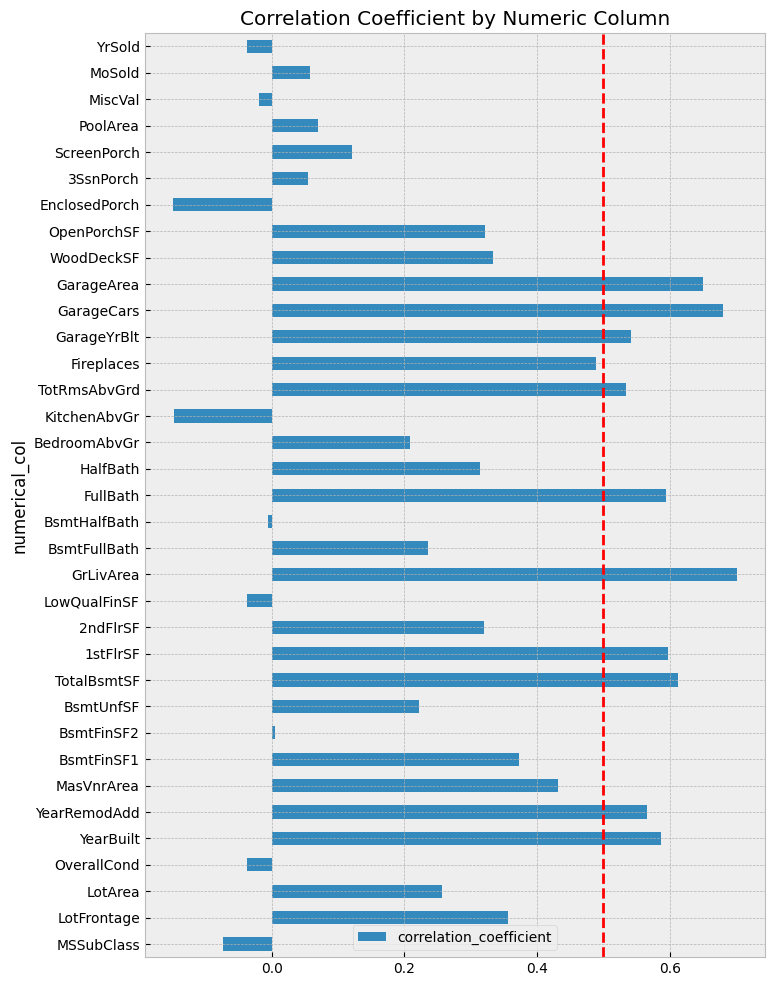

In [59]:
ax = corr_df.plot(x='numerical_col', kind='barh', figsize=(8, 12))
ax.axvline(0.5, color='r', ls='--');
ax.set_title('Correlation Coefficient by Numeric Column');

# 4) Categorical Column vs Target

In [60]:
cat_df = train_df[cat_cols + ['log_sale_price']].copy()
print(cat_df.shape)
cat_df.head(2)

(1460, 45)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,log_sale_price
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,12.247694
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,12.109011


## a) Anova

In [61]:
from scipy.stats import f_oneway
f_stat_list = []
p_value_list = []
for cat in cat_cols:
    group_res = cat_df.groupby([cat])['log_sale_price']
    groups = [group for name, group in group_res]
    f_stat, p_value = f_oneway(*groups)
    f_stat_list.append(f_stat)
    p_value_list.append(p_value)

In [62]:
f_df = pd.DataFrame({'cat': cat_cols, 
                     'f_stat': f_stat_list, 
                     'p_value': p_value_list})
f_df['is_significant'] = np.where(0, 1, f_df.p_value<0.05)
print(f_df.shape)
f_df.head(7)

(44, 4)


,cat,f_stat,p_value,is_significant
0,MSZoning,77.607843,1.021343e-59,1
1,Street,4.814455,2.837931e-02,1
2,Alley,27.007388,1.277140e-06,1
3,LotShape,46.728762,7.856968e-29,1
4,LandContour,12.767270,3.086224e-08,1
5,Utilities,0.232689,6.296094e-01,0
6,LotConfig,8.692440,6.214575e-07,1


In [63]:
sig_cat_cols = f_df[f_df.is_significant==1].cat.tolist()
len(sig_cat_cols)

39

In [64]:
# these columns have a significant relationship with target. use these columns
print('significant cols', f_df[f_df.is_significant==1].shape[0])
f_df[f_df.is_significant==1].sort_values(by='f_stat', ascending=False)

significant cols 39


,cat,f_stat,p_value,is_significant
19,ExterQual,415.303357,6.935425e-195,1
31,KitchenQual,393.320196,4.441486e-187,1
22,BsmtQual,364.727160,1.481415e-175,1
13,OverallQual,332.166377,0.000000e+00,1
35,GarageFinish,328.927449,1.759326e-117,1
29,CentralAir,205.666987,9.855628e-44,1
21,Foundation,126.806748,1.350671e-111,1
18,MasVnrType,115.071986,7.806731e-67,1
28,HeatingQC,110.820436,1.614882e-82,1
34,GarageType,101.162911,5.885122e-91,1


## b) Chart Distribution

In [65]:
width = 400
height = 100
chart_list = []
for col in cat_cols:
    c = alt.Chart(train_df).mark_bar().encode(y=col, 
                                       x='mean(log_sale_price)').properties(width=width, 
                                                                            height=height, title = f'log_sale_price vs {col.title()}')
    chart_list.append(c)

dict_v = {}
for item in np.arange(0, 50, 10):
    dict_v[f"ca_{item}"] = alt.vconcat(*chart_list[item:item+10])
alt.hconcat(*list(dict_v.values()))

alt.HConcatChart(...)

## c) OverallQual

#we treat OverallQual as a categorical feature

Text(0.5, 1.0, 'Log Sale Price vs Overall Qual')

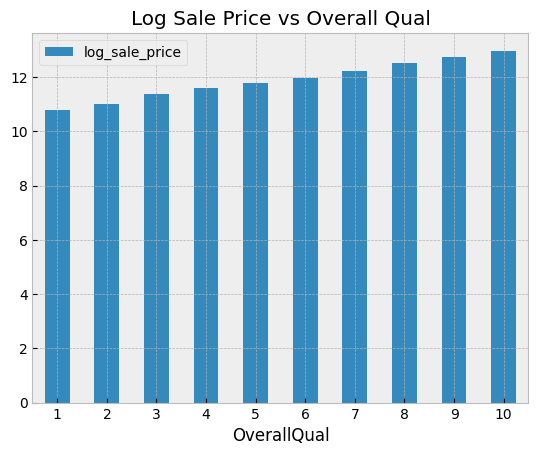

In [167]:
ax = train_df.groupby(['OverallQual']).agg({'log_sale_price': 'median'}).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Log Sale Price vs Overall Qual')

# 5) Model trials: Basic Pipeline

#learnings from EDA
1. skew and kurtosis value for a few columns look high. so, it's better to use robustscaler while scaling.
2. coverage is almost full for most. we can impute the remaining null values
3. these are highly correlated fields with target. we should use them in modeling
4. correlation below zero isn't too high and is closer to zero. we can ignore these fields.
5. these columns have a significant relationship with target. use these columns

In [91]:
id_cols = ['Id', 'SalePrice']
target_cols = ['log_sale_price']
numeric_cols = [col for col in train_df._get_numeric_data().columns if (col not in target_cols) and (col not in id_cols) and (col not in ['OverallQual'])]
cat_cols = [col for col in train_df.columns if (col not in numeric_cols) and (col not in target_cols) and (col not in id_cols)]
len(numeric_cols), len(target_cols), len(cat_cols)

(35, 1, 44)

## a) Running all Regressors: No changes

In [125]:
X_train = train_df[numeric_cols + cat_cols]
y_train = train_df[target_cols]
print(X_train.shape, y_train.shape)

(1460, 79) (1460, 1)


In [126]:
from sklearn.pipeline import Pipeline
import regressor_models
def run_all_pipeline(chosen_model, X_train, y_train):
    
    model_pipe = Pipeline(steps=[('preprocess', regressor_models.PreProcessData(numerical_cols=numeric_cols, categorical_cols=cat_cols)), 
                                 ('model', chosen_model), 
                                ])
    base_reg = regressor_models.BaseRegressor(model=model_pipe)
    base_reg.fit(X_train, y_train);
    y_pred_train = base_reg.predict(X_train)
    
    mae_scorer = base_reg.evaluate(y_train, y_pred_train, metric='mae')
    r2_scorer = base_reg.evaluate(y_train, y_pred_train, metric='r2_score')
    rmse_scorer = base_reg.evaluate(y_train, y_pred_train, metric='rmse')
    
    score_dict = dict()
    score_dict['train_mae'] = mae_scorer
    score_dict['train_r2'] = r2_scorer
    score_dict['train_rmse'] = rmse_scorer
    
    return score_dict, base_reg

In [127]:
random_forest_args = dict(n_estimators=600, max_depth=12, min_samples_split=30, max_features=0.7)
xgboost_args = dict(n_estimators=600, max_depth=12, learning_rate=0.03, min_child_weight=30, subsample=0.6)
chosen_model_dict = {'linear_regression': regressor_models.LinearRegressor(), 
                     'random_forest': regressor_models.RandomForest(**random_forest_args), 
                     'xgboost': regressor_models.XGBoost(**xgboost_args)
                    }

In [128]:
%%time
chosen_model_name_list = []
score_dict_list = []
model_artifacts_list = []

for chosen_model_name, chosen_model in chosen_model_dict.items():
    
    score_dict, base_reg = run_all_pipeline(chosen_model, X_train, y_train)
    chosen_model_name_list.append(chosen_model_name)
    score_dict_list.append(score_dict)
    model_artifacts_list.append(base_reg)

/Users/rdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: user 34.9 s, sys: 811 ms, total: 35.7 s
Wall time: 24.5 s


In [129]:
temp = pd.DataFrame(score_dict_list)
score_df = pd.DataFrame({'chosen_model': chosen_model_name_list})
score_df = pd.concat([score_df, temp], axis=1).reset_index(drop=True).copy()
score_df = score_df.sort_values(by='train_mae', ascending=True).reset_index(drop=True).copy()
score_df

,chosen_model,train_mae,train_r2,train_rmse
0,xgboost,0.031798,0.981511,0.054297
1,linear_regression,0.064981,0.945029,0.093623
2,random_forest,0.073896,0.926283,0.108418


In [511]:
# Ran all features, all regressors, basic preprocessing

#learnings
# 1. all features are used. not all are important.
# 2. results are highly overfitted.
# 3. xgboost seems to be the best performer.  will deal with this later 
# 4. train r2 is good, but train MAE is high. scale of y is high. will deal with this later 

In [512]:
# Lets resolve # 1 and # 2 in next training iteration.

# b) Run all regressors: imp features, little tuning

In [130]:
# high_correlated_fields are important fields from numeric cols
# sig_cat_cols are important fields from categorical cols.
import regressor_models
pp_data_pipe = regressor_models.PreProcessData(numerical_cols=high_correlated_fields, 
                                               categorical_cols=sig_cat_cols)

In [131]:
target_cols = ['log_sale_price']
X_train = train_df[high_correlated_fields + sig_cat_cols]
y_train = train_df[target_cols]
print(X_train.shape, y_train.shape)

(1460, 49) (1460, 1)


In [132]:
# we are now down to 48 columns from 79 columns, which hopefully make the predictions better.

In [133]:
from sklearn.pipeline import Pipeline
def run_all_pipeline(chosen_model, X_train, y_train):
    
    model_pipe = Pipeline(steps=[
        ('preprocess', pp_data_pipe), 
        ('model', chosen_model), 
    ])
    base_reg = regressor_models.BaseRegressor(model=model_pipe)
    base_reg.fit(X_train, y_train);
    
    y_pred_train = base_reg.predict(X_train)
    train_mae_scorer = base_reg.evaluate(y_train, y_pred_train, metric='mae')
    train_r2_scorer = base_reg.evaluate(y_train, y_pred_train, metric='r2_score')
    train_rmse_scorer = base_reg.evaluate(y_train, y_pred_train, metric='rmse')

    score_dict = dict()
    score_dict['train_mae'] = train_mae_scorer
    score_dict['train_r2'] = train_r2_scorer
    score_dict['train_rmse'] = train_rmse_scorer
    
    return score_dict, base_reg

In [134]:
random_forest_args = dict(n_estimators=400, max_depth=4, min_samples_split=50, 
                          max_features=0.3)
xgboost_args = dict(n_estimators=900, max_depth=12, learning_rate=0.03, min_child_weight=30, subsample=0.7)
ridge_args = dict(alpha=2)
chosen_model_dict = {'linear_regression_w_ridge': regressor_models.RidgeRegressor(), 
                     'random_forest': regressor_models.RandomForest(**random_forest_args), 
                     'xgboost': regressor_models.XGBoost(**xgboost_args)
                    }

In [135]:
%%time
chosen_model_name_list = []
score_dict_list = []
model_artifacts_list = []

for chosen_model_name, chosen_model in chosen_model_dict.items():
    
    score_dict, base_reg = run_all_pipeline(chosen_model, X_train, y_train)
    chosen_model_name_list.append(chosen_model_name)
    score_dict_list.append(score_dict)
    model_artifacts_list.append(base_reg)

/Users/rdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: user 18 s, sys: 809 ms, total: 18.8 s
Wall time: 5.32 s


In [136]:
temp = pd.DataFrame(score_dict_list)
score_df = pd.DataFrame({'chosen_model': chosen_model_name_list})
score_df = pd.concat([score_df, temp], axis=1).reset_index(drop=True).copy()
score_df = score_df.sort_values(by='train_mae', ascending=True).reset_index(drop=True).copy()
score_df

,chosen_model,train_mae,train_r2,train_rmse
0,xgboost,0.030397,0.985877,0.047454
1,linear_regression_w_ridge,0.076693,0.927157,0.107773
2,random_forest,0.117767,0.821341,0.168783


In [615]:
# don't see any improvement since the last change. # lets look at feature importance of the best performer which is xgboost.

In [148]:
feature_names = model_artifacts_list[chosen_model_name_list.index('xgboost')].model.steps[0][1].get_feature_names_out()
feature_importances = model_artifacts_list[chosen_model_name_list.index('xgboost')].model.steps[1][1].model.feature_importances_
len(feature_names), len(feature_importances)

f_df = pd.DataFrame({'feature_name': feature_names, 
                     'feature_importances': feature_importances})
f_df['feature_importances'] = f_df['feature_importances']*100
f_df = f_df.sort_values(by='feature_importances', ascending=False).reset_index(drop=True).copy()
print(f_df.shape)
f_df.head(20)

(267, 2)


,feature_name,feature_importances
0,ExterQual_TA,21.210773
1,BsmtQual_Ex,5.684691
2,GarageCars,4.841763
3,FireplaceQu_nan,3.948247
4,GrLivArea,3.842963
5,YearBuilt,3.442302
6,KitchenQual_Ex,3.345390
7,KitchenQual_TA,3.195272
8,CentralAir_N,2.797288
9,KitchenQual_Fa,2.119951


In [ ]:
# this gives us the top 20 features. 
# interesting to see how important is OverallQual

In [149]:
# features with zero importance
f_df[f_df.feature_importances==0].shape[0]*100 / f_df.shape[0]

49.438202247191015

In [461]:
# there are still 49 features in the model, and only around 50% of features are important. This is high number. Let's try PCA to reduce that number to 10.

## c) Run all regressors: Add PCA and Truncated SVD

In [150]:
# high_correlated_fields are important fields from numeric cols
# sig_cat_cols are important fields from categorical cols.
import regressor_models
pp_data_pipe = regressor_models.PreProcessData(numerical_cols=high_correlated_fields, 
                                               categorical_cols=sig_cat_cols, 
                                               apply_pca=True, 
                                               apply_svd=True, 
                                               n_components_num=10, 
                                               n_components_cat=10)

In [151]:
target_cols = ['log_sale_price']
X_train = train_df[high_correlated_fields + sig_cat_cols]
y_train = train_df[target_cols]
print(X_train.shape, y_train.shape)

(1460, 49) (1460, 1)


In [152]:
def run_all_pipeline_w_pcs(chosen_model, X_train, y_train):
    
    model_pipe = Pipeline(steps=[
        ('preprocess', pp_data_pipe), 
        ('model', chosen_model), 
    ])
    base_reg = regressor_models.BaseRegressor(model=model_pipe)
    base_reg.fit(X_train, y_train);
    
    y_pred_train = base_reg.predict(X_train)
    
    train_mae_scorer = base_reg.evaluate(y_train, y_pred_train, metric='mae')
    train_r2_scorer = base_reg.evaluate(y_train, y_pred_train, metric='r2_score')
    train_rmse_scorer = base_reg.evaluate(y_train, y_pred_train, metric='rmse')
    
    
    score_dict = dict()
    score_dict['train_mae'] = train_mae_scorer
    score_dict['train_r2'] = train_r2_scorer
    score_dict['train_rmse'] = train_rmse_scorer
    
    return score_dict

In [153]:
random_forest_args = dict(n_estimators=400, max_depth=4, min_samples_split=50, 
                          max_features=0.3)
xgboost_args = dict(n_estimators=900, max_depth=12, learning_rate=0.03, min_child_weight=30, subsample=0.7)
ridge_args = dict(alpha=2)
chosen_model_dict = {'linear_regression_w_ridge': regressor_models.RidgeRegressor(), 
                     'random_forest': regressor_models.RandomForest(**random_forest_args), 
                     'xgboost': regressor_models.XGBoost(**xgboost_args)
                    }

In [154]:
%%time
chosen_model_name_list = []
score_dict_list = []
model_artifacts_list = []

for chosen_model_name, chosen_model in chosen_model_dict.items():
    
    score_dict, base_reg = run_all_pipeline(chosen_model, X_train, y_train)
    chosen_model_name_list.append(chosen_model_name)
    score_dict_list.append(score_dict)
    model_artifacts_list.append(base_reg)

/Users/rdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


CPU times: user 17.7 s, sys: 838 ms, total: 18.5 s
Wall time: 4.57 s


In [155]:
temp = pd.DataFrame(score_dict_list)
score_df = pd.DataFrame({'chosen_model': chosen_model_name_list})
score_df = pd.concat([score_df, temp], axis=1).reset_index(drop=True).copy()
score_df = score_df.sort_values(by='train_mae', ascending=True).reset_index(drop=True).copy()
score_df

,chosen_model,train_mae,train_r2,train_rmse
0,xgboost,0.021124,0.992513,0.034552
1,linear_regression_w_ridge,0.110114,0.838591,0.160428
2,random_forest,0.122824,0.804538,0.176541


In [156]:
final_model = model_artifacts_list[chosen_model_name_list.index('xgboost')].model

In [157]:
X_test = test_df[high_correlated_fields + sig_cat_cols]
y_test = test_df['log_sale_price']
y_pred_test = final_model.predict(X_test)

In [158]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)**0.5

0.3761099321008642

# 6) Stacking all regressors

## a) Implement Stacking Regressor

In [168]:
from sklearn.ensemble import StackingRegressor

In [160]:
# high_correlated_fields are important fields from numeric cols
# sig_cat_cols are important fields from categorical cols.
import regressor_models
pp_data_pipe = regressor_models.PreProcessData(numerical_cols=high_correlated_fields, 
                                               categorical_cols=sig_cat_cols, 
                                               apply_pca=True, 
                                               apply_svd=True, 
                                               n_components_num=10, 
                                               n_components_cat=10)

In [161]:
target_cols = ['log_sale_price']
X_train = train_df[high_correlated_fields + sig_cat_cols]
y_train = train_df[target_cols]
print(X_train.shape, y_train.shape)

(1460, 49) (1460, 1)


In [162]:
random_forest_args = dict(n_estimators=600, max_depth=5, min_samples_split=20, max_features=0.6)
xgboost_args = dict(n_estimators=600, max_depth=12, learning_rate=0.005, min_child_weight=30, subsample=0.6)
ridge_args = dict(alpha=1)
final_estimator_args = dict(n_estimators=1200, max_depth=12, min_child_weight=10, learning_rate=0.0007, subsample=0.8)

stacking_reg_pipe = Pipeline(steps=[('preprocess_data', pp_data_pipe), 
                                    ('stacking_regressor', StackingRegressor(estimators=[('lin_mod', regressor_models.RidgeRegressor(**ridge_args)), 
                                                                                         ('rf_mod', regressor_models.RandomForest(**random_forest_args)), 
                                                                                         ('xg_mod', regressor_models.XGBoost(**xgboost_args))
                                                                                        ], 
                                                                             final_estimator=regressor_models.XGBoost(**final_estimator_args)))
                                   ])
stacking_reg_pipe.fit(X_train, y_train);
y_pred_train = stacking_reg_pipe.predict(X_train)

/Users/rdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [169]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
train_mae_scorer = mean_absolute_error(y_train, y_pred_train)
train_r2_scorer = r2_score(y_train, y_pred_train)
train_rmse_scorer = mean_squared_error(y_train, y_pred_train)**0.5

score_dict = dict()
score_dict['train_mae'] = train_mae_scorer
score_dict['train_r2'] = train_r2_scorer
score_dict['train_rmse'] = train_rmse_scorer

score_df = pd.DataFrame([score_dict])
score_df = score_df.sort_values(by='train_mae', ascending=True).reset_index(drop=True).copy()
score_df

,train_mae,train_r2,train_rmse
0,0.157305,0.708107,0.215739


## b) Test on test data

In [170]:
X_test = test_df[high_correlated_fields + sig_cat_cols]
y_test = test_df['log_sale_price']
y_pred_test = stacking_reg_pipe.predict(X_test)

In [171]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)**0.5

0.2167297307014418

In [936]:
# we can spend more time and improve the results by doing some feature engineering, and seeing the error distribution by feature.

# 7) Prediction

In [941]:
prep_df = pd.DataFrame({'Id': test_df['Id'], 
                              'pred_SalePrice': np.exp(y_pred_test), 
                              'SalePrice': test_df.SalePrice})
print(prep_df.shape)
prep_df.head(2)

(1459, 3)


,Id,pred_SalePrice,SalePrice
0,1461,133867.843750,169277.052498
1,1462,161339.984375,187758.393989


In [942]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(prep_df.SalePrice, prep_df.pred_SalePrice)**0.5 

0.2195758631250099

In [943]:
submission_df = prep_df[['Id', 'pred_SalePrice']].copy()
submission_df.rename(columns={'pred_SalePrice': 'SalePrice'}, inplace=True)
print(submission_df.shape)
submission_df.head(2)

(1459, 2)


,Id,SalePrice
0,1461,133867.843750
1,1462,161339.984375


In [949]:
submission_df.to_csv('../datasets/predicting_house_prices/my_submission.csv', sep=',', index=False)